In [248]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [249]:
##Data load

df = pd.read_csv(
  "household loan.csv",
  parse_dates=['date'],
  index_col="date"
)

df.columns

Index(['household_loan', 'loan interest rate'], dtype='object')

In [250]:
#Preprocessing dataset

index_list = df.index.tolist()
df = pd.DataFrame(data=df, index=index_list, columns=df.columns)

# convert index to datetime index
df.index = pd.to_datetime(df.index.str.replace('/Q', '-'), format='%Y-%m')

# replace commas in string column with an empty string
df['household_loan'] = df['household_loan'].str.replace(',', '')

# convert the column to float type
df['household_loan'] = df['household_loan'].astype(float)

In [251]:
def series_to_supervised(data, n_in=12, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values


In [252]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    
     # transform list into array
    train = np.array(train)
    # split into input and output columns
    trainX, trainy = train[:, 1:], train[:, 0]

    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(testX.reshape(1, -1))
    return yhat[0]

In [253]:

def walk_forward_validation(data, n_test, eval_set_size=4):
    
    train_size = len(data) - n_test - eval_set_size
    train, test = data[:train_size, :], data[train_size:(train_size+n_test), :]
    eval_set = train[-eval_set_size:, :]
    train = train[:-eval_set_size, :]
    
    # seed history with training dataset
    history = [x for x in train]
    
    # make predictions on evaluation set
    eval_predictions = []
    eval_actuals = []
    eval_mae=[]
    eval_mse=[]
    
    for i in range(len(eval_set)):
        evalX, evaly = eval_set[i, 1:], eval_set[i, 0]
        eval_yhat = xgboost_forecast(history, evalX)
        eval_predictions.append(eval_yhat)
        eval_actuals.append(evaly)
        
        # summarize progress
        print('>eval_expected=%.1f, eval_predicted=%.1f' % (evaly, eval_yhat))
        
        eval_mae.append(mean_absolute_error(eval_actuals, eval_predictions))
        eval_mse.append(mean_squared_error(eval_actuals, eval_predictions))
    
    
    predictions = []
    actuals = []
    test_mse=[]
    test_mae=[]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, 1:], test[i, 0]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        actuals.append(testy)
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
        
        # estimate prediction error
        test_mse.append(mean_squared_error(actuals, predictions))
        test_mae.append(mean_absolute_error(actuals, predictions)) 
        
    return test_mse, test_mae, actuals, predictions, eval_mae, eval_mse, eval_actuals, eval_predictions


In [254]:
values = df.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=12)

test_mse, test_mae, actuals, predictions, eval_mae, eval_mse, eval_actuals, eval_predictions = walk_forward_validation(data, 8)  # using 8 quarters for test dataset


print('Test MSE: %.3f' % np.mean(test_mse))
print('Test MAE: %.3f' % np.mean(test_mae))
print('Evaluation MSE: %.3f' % np.mean(eval_mse))
print('Evaluation MAE: %.3f' % np.mean(eval_mae))

>eval_expected=1158.5, eval_predicted=1137.9
>eval_expected=1191.6, eval_predicted=1137.9
>eval_expected=1228.6, eval_predicted=1137.9
>eval_expected=1269.8, eval_predicted=1137.9
>expected=1286.0, predicted=1105.3
>expected=1312.8, predicted=1255.7
>expected=1341.1, predicted=1312.8
>expected=1369.8, predicted=1341.1
>expected=1387.1, predicted=1369.8
>expected=1409.2, predicted=1387.1
>expected=1427.2, predicted=1397.7
>expected=1446.6, predicted=1427.2
Test MSE: 12089.309
Test MAE: 84.984
Evaluation MSE: 3284.002
Evaluation MAE: 46.676


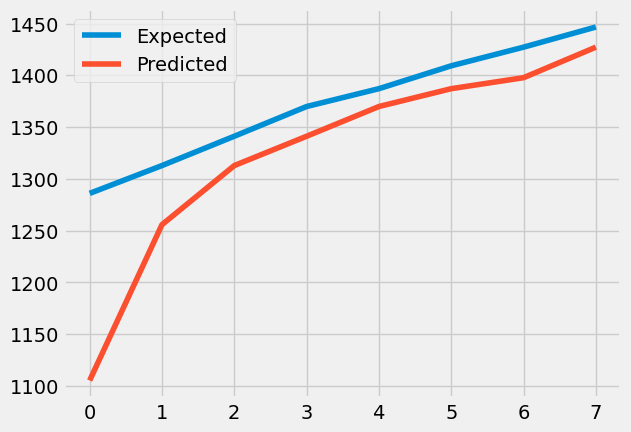

In [255]:
# plot expected vs predicted
fig = pyplot.figure(figsize=(15, 5))
pyplot.plot(actuals, label='Expected')
pyplot.plot(predictions, label='Predicted')
pyplot.legend()
pyplot.show()